# paddleOCR — Evaluation & Debug Notebook  
**Author:** Manel

## Purpose
Evaluate paddleOCR on document pages (PDF → images) with:
- Visual inspection (original + preprocessed)
- OCR text preview
- Word-level bounding boxes and confidence
- Quick sweeps over preprocessing + `psm` layouts


#### Imports

In [1]:
import os
from pathlib import Path
from typing import List, Dict, Any
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from paddleocr import PaddleOCR
import cv2
from IPython.display import display
import pandas as pd
from pytesseract import Output
import numpy as np
from PIL import Image, ImageOps, ImageEnhance

C:\Users\manel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Checking connectivity to the model hosters, this may take a while. To bypass this check, set `PADDLE_PDX_DISABLE_MODEL_SOURCE_CHECK` to `True`.


#### Paths

In [2]:
BASE_DIR = Path.cwd()  # ...\DocumentAgent\Notebooks
DATA_DIR = BASE_DIR.parent / "data" / "images"

#### Display Helpers

In [3]:
def show(img, title=None, figsize=(10, 12)):
    if isinstance(img, (str, Path)):
        img = Image.open(img)
    plt.figure(figsize=figsize)
    cmap = "gray" if img.mode in ["L", "1"] else None
    plt.imshow(img, cmap=cmap)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()

def crop(img, x1, y1, x2, y2):
    if isinstance(img, (str, Path)):
        img = Image.open(img)
    return img.crop((x1, y1, x2, y2))

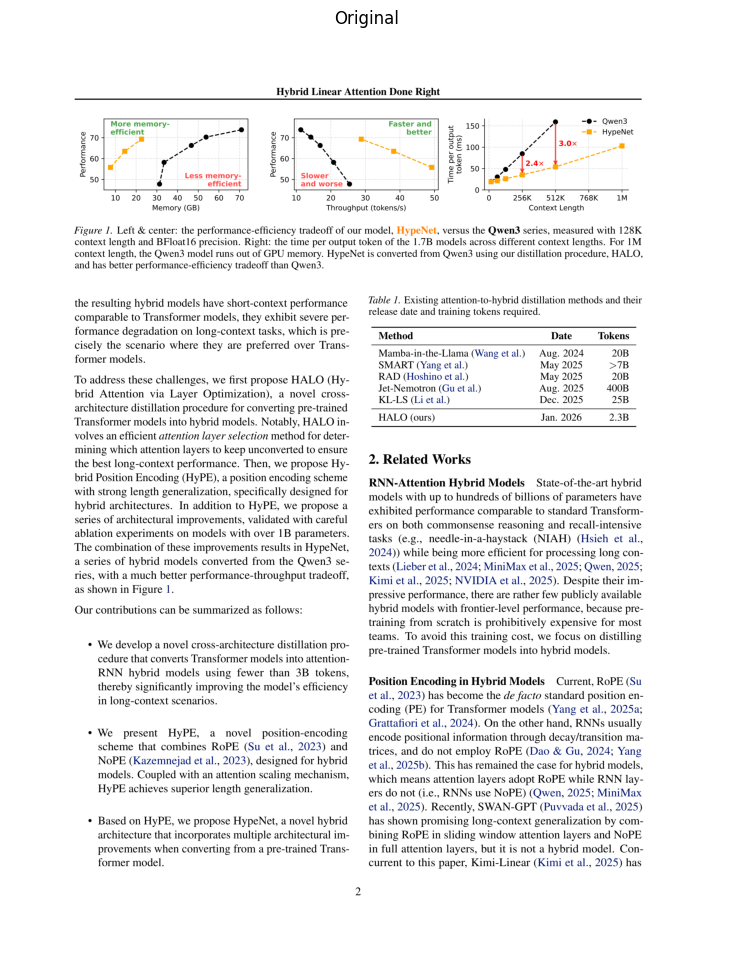

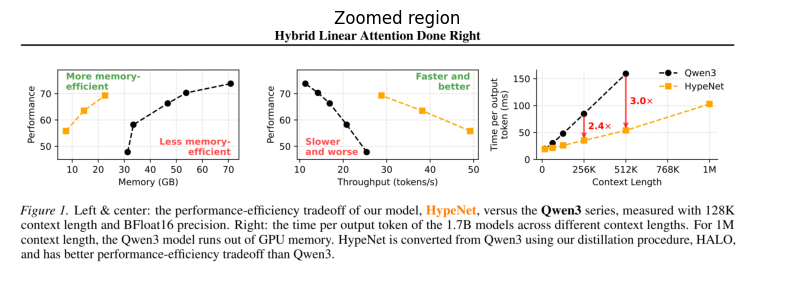

In [4]:
# Example usage
DEFAULT_IMAGE = DATA_DIR / "page_2.png"
show(DEFAULT_IMAGE, "Original")
show(crop(DEFAULT_IMAGE, 200, 200, 2400, 900), "Zoomed region")

#### Set paddleOCR

In [5]:
ocr = PaddleOCR(lang='en')

C:\Users\manel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\paddle\utils\cpp_extension\extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\manel\.paddlex\official_models\PP-LCNet_x1_0_doc_ori`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\manel\.paddlex\official_models\UVDoc`.
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\manel\.paddlex\offici

In [6]:
DEFAULT_IMAGE

WindowsPath('c:/Users/manel/OneDrive/Escritorio/OCR/DocumentAgent/data/images/page_2.png')

In [7]:
result = ocr.predict('c:/Users/manel/OneDrive/Escritorio/OCR/DocumentAgent/data/images/page_2.png')

In [8]:
page = result[0]
texts = page['rec_texts'] # recognized text strings
scores = page['rec_scores'] # confidence scores for each text line
boxes  = page['rec_polys'] #  bounding box coordinates

for text, score, box in zip(texts, scores, boxes):
    # box is a numpy array like [[x1, y1], [x2, y2], [x3, y3], [x4, y4]]
    coords = box.astype(int).tolist()  # convert to normal list of ints
    print(f"{text:25} | {score:.3f} | {coords}")

Hybrid Linear Attention Done Right | 0.979 | [[949, 27], [1606, 64], [1603, 118], [946, 81]]
More memory-              | 0.999 | [[301, 160], [536, 172], [535, 207], [299, 195]]
efficient                 | 0.963 | [[302, 194], [444, 201], [442, 237], [300, 230]]
Faster and                | 0.999 | [[1392, 191], [1567, 200], [1566, 235], [1390, 226]]
Qwen3                     | 1.000 | [[2209, 191], [2319, 195], [2318, 232], [2208, 228]]
Performance               | 1.000 | [[181, 204], [213, 203], [219, 406], [188, 407]]
70                        | 1.000 | [[216, 216], [269, 216], [269, 257], [216, 257]]
Performance               | 1.000 | [[930, 217], [963, 218], [958, 415], [924, 414]]
150                       | 1.000 | [[1688, 208], [1754, 208], [1754, 246], [1688, 246]]
70                        | 1.000 | [[964, 226], [1017, 231], [1013, 272], [960, 267]]
better                    | 1.000 | [[1460, 227], [1568, 233], [1566, 268], [1458, 262]]
Time per output           | 0.999 | [[1

In [9]:
img = page['doc_preprocessor_res']['output_img']

### Extracted lines & bounding boxes (processed image)

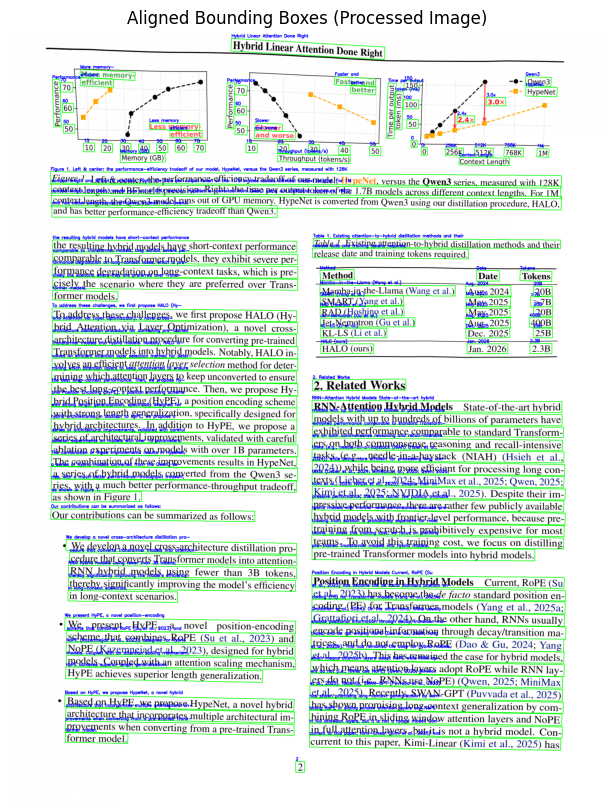

In [10]:
img_plot = img.copy()

for text, box in zip(texts, boxes):
    pts = np.array(box, dtype=int)
    cv2.polylines(img_plot, [pts], True, (0, 255, 0), 2)
    x, y = pts[0]
    cv2.putText(img_plot, text, (x, y - 5), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

plt.figure(figsize=(8, 10))
plt.imshow(cv2.cvtColor(img_plot, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Aligned Bounding Boxes (Processed Image)")
plt.show()

In [11]:
def extract_page_fields(result, page_idx=0):
    """Extract PaddleOCR page fields with basic validation."""
    if not result or page_idx >= len(result):
        raise ValueError(f"`result` is empty or page_idx={page_idx} out of range.")

    page = result[page_idx]
    required = ["rec_texts", "rec_scores", "rec_polys"]
    missing = [k for k in required if k not in page]
    if missing:
        raise KeyError(f"Missing keys in page dict: {missing}")

    texts  = page["rec_texts"]
    scores = page["rec_scores"]
    boxes  = page["rec_polys"]

    if not (len(texts) == len(scores) == len(boxes)):
        raise ValueError(
            f"Length mismatch: texts={len(texts)}, scores={len(scores)}, boxes={len(boxes)}"
        )

    # Image (optional)
    img = None
    try:
        img = page["doc_preprocessor_res"]["output_img"]
    except Exception:
        pass

    return page, texts, scores, boxes, img


def print_ocr_lines(texts, scores, boxes, min_score=0.0, top_k=None, text_width=40):
    """Pretty-print OCR results as a table-like output."""
    rows = []
    for t, s, b in zip(texts, scores, boxes):
        if s < min_score:
            continue
        coords = np.asarray(b).astype(int).tolist()
        rows.append((t, float(s), coords))

    # Sort by confidence (descending) if you want a "study" feel
    rows.sort(key=lambda x: x[1], reverse=True)

    if top_k is not None:
        rows = rows[:top_k]

    # Header
    print(f"{'text':{text_width}} | {'conf':>6} | box")
    print("-" * (text_width + 3 + 6 + 3 + 30))

    # Rows
    for t, s, coords in rows:
        t_fmt = (t[: text_width - 1] + "…") if len(t) > text_width else t
        print(f"{t_fmt:{text_width}} | {s:6.3f} | {coords}")


def draw_ocr_boxes(img, texts, boxes, scores=None, min_score=0.0,
                   box_thickness=2, font_scale=0.6):
    """
    Draw polygons + labels on a copy of img.
    If scores is given, filters by min_score.
    """
    if img is None:
        raise ValueError("No image available to draw on (img is None).")

    img_plot = img.copy()

    for i, (t, b) in enumerate(zip(texts, boxes)):
        s = scores[i] if scores is not None else 1.0
        if s < min_score:
            continue

        pts = np.asarray(b, dtype=int)

        # Draw polygon
        cv2.polylines(img_plot, [pts], isClosed=True, color=(0, 255, 0), thickness=box_thickness)

        # Put label near top-left-ish point
        x, y = int(pts[0][0]), int(pts[0][1])
        label = f"{t}"
        if scores is not None:
            label = f"{t} ({s:.2f})"

        cv2.putText(
            img_plot, label,
            (x, max(0, y - 6)),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale, (255, 0, 0), 2, cv2.LINE_AA
        )

    return img_plot


def show_image(img, title=None, figsize=(10, 12)):
    """Show image with best-effort color handling (BGR->RGB if needed)."""
    # Heuristic: if it looks like a typical OpenCV BGR image, convert
    img_show = img
    if img.ndim == 3 and img.shape[2] == 3:
        # assume BGR (most common from cv2 / Paddle doc preprocessor)
        img_show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=figsize)
    plt.imshow(img_show)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()

### EXECUTIONS

In [13]:
def run_paddle (image_path):
    result = ocr.predict(image_path)
    page, texts, scores, boxes, img = extract_page_fields(result, page_idx=0)
    print_ocr_lines(texts, scores, boxes, min_score=0.50, top_k=50, text_width=45)
    if img is not None:
        img_annot = draw_ocr_boxes(img, texts, boxes, scores=scores, min_score=0.50)
        show_image(img_annot, title="Aligned Bounding Boxes (Processed Image)")
    else:
        print("No preprocessed image found at page['doc_preprocessor_res']['output_img'].")

In [14]:
PATH1 = 'c:/Users/manel/OneDrive/Escritorio/OCR/DocumentAgent/data/images/page_1.png'
PATH2 = 'c:/Users/manel/OneDrive/Escritorio/OCR/DocumentAgent/data/images/page_2.png'
PATH3 = 'c:/Users/manel/OneDrive/Escritorio/OCR/DocumentAgent/data/images/page_3.png'
PATH4 = 'c:/Users/manel/OneDrive/Escritorio/OCR/DocumentAgent/data/images/page_7.png'
PATH5 = 'c:/Users/manel/OneDrive/Escritorio/OCR/DocumentAgent/data/images/TFG1.png'

## Execution 1 — Simple text-only page

**Document characteristics**
- Single paper page
- Text-only content
- No charts, tables or complex layouts
- Standard academic-style formatting

**Objective**
Evaluate baseline OCR performance on a clean document page without structural complexity.

text                                          |   conf | box
---------------------------------------------------------------------------------------
Abstract                                      |  1.000 | [[548, 919], [762, 916], [763, 965], [548, 968]]
1                                             |  1.000 | [[1220, 3167], [1252, 3167], [1252, 3211], [1220, 3211]]
NVIDIA et al., 2025).                         |  1.000 | [[1280, 1840], [1699, 1842], [1699, 1890], [1280, 1888]]
long-context performance, which is the scena… |  1.000 | [[183, 1831], [1115, 1827], [1116, 1878], [183, 1882]]
1. Introduction                               |  1.000 | [[1281, 916], [1645, 919], [1644, 968], [1281, 965]]
1NLP Group, DCST, IAI, BNRIST, Tsinghua Univ… |  0.999 | [[431, 631], [1782, 631], [1782, 685], [431, 685]]
trast, recurrent neural networks (RNNs) such… |  0.999 | [[1280, 1238], [2372, 1247], [2371, 1291], [1280, 1282]]
ever, these transfer methods require substan… |  0.999 | [[186, 1671], [1

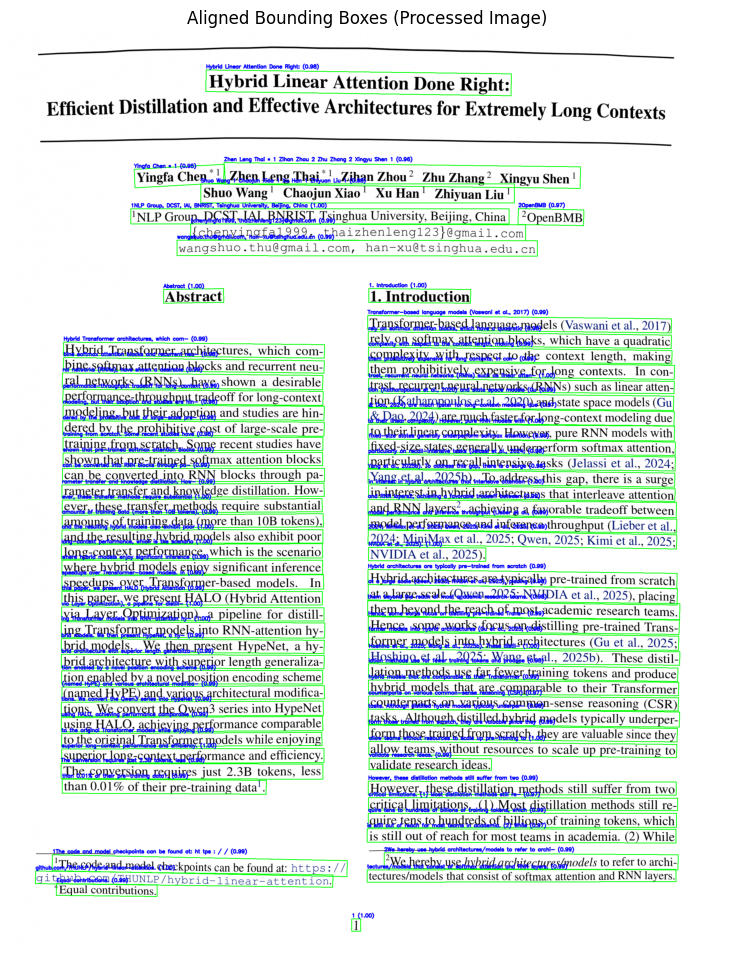

In [15]:
run_paddle('c:/Users/manel/OneDrive/Escritorio/OCR/DocumentAgent/data/images/page_1.png')

### Observations

- Recovers **most of the document text** correctly (titles, authors, body paragraphs)
- **Second title is not detected**, likely due to layout or stylistic differences.
- Remaining section titles and paragraphs are **mostly accurate**.
- Suitable for **readability**, but limited for **layout-aware analysis**.

### Execution2

text                                          |   conf | box
---------------------------------------------------------------------------------------
256K                                          |  1.000 | [[1865, 497], [1943, 497], [1943, 530], [1865, 530]]
150                                           |  1.000 | [[1688, 208], [1754, 208], [1754, 246], [1688, 246]]
512K                                          |  1.000 | [[1991, 495], [2071, 498], [2070, 534], [1990, 531]]
100                                           |  1.000 | [[1685, 291], [1751, 291], [1751, 329], [1685, 329]]
70                                            |  1.000 | [[788, 477], [837, 477], [837, 514], [788, 514]]
HypeNet                                       |  1.000 | [[2211, 235], [2345, 237], [2344, 277], [2210, 274]]
Method                                        |  1.000 | [[1328, 1021], [1474, 1017], [1476, 1060], [1330, 1064]]
768K                                          |  1.000 | [[2118, 495], [2200, 498

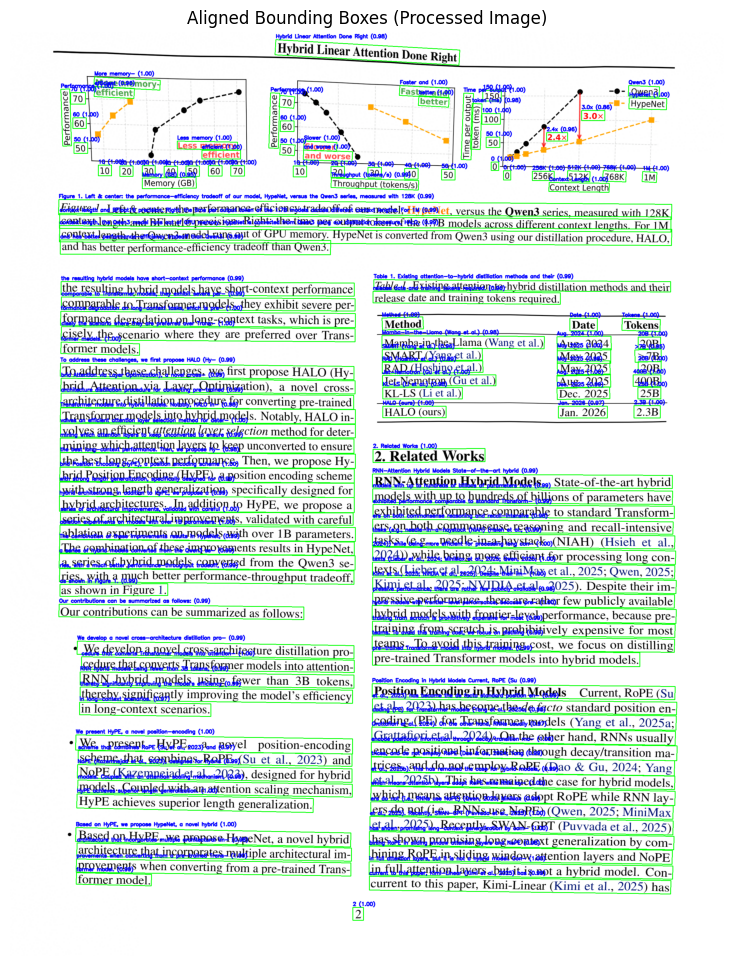

In [16]:
run_paddle('c:/Users/manel/OneDrive/Escritorio/OCR/DocumentAgent/data/images/page_2.png')

### Observations


### Execution3

text                                          |   conf | box
---------------------------------------------------------------------------------------
length generalization.                        |  1.000 | [[193, 1986], [585, 1975], [586, 2020], [194, 2031]]
otherwise.                                    |  1.000 | [[820, 3122], [1012, 3115], [1014, 3164], [822, 3171]]
3                                             |  1.000 | [[1240, 3222], [1277, 3220], [1281, 3271], [1243, 3274]]
Modeling and Length Generalization            |  1.000 | [[1386, 2539], [2103, 2533], [2104, 2583], [1387, 2589]]
(4)                                           |  1.000 | [[2301, 944], [2369, 944], [2369, 1000], [2301, 1000]]
(6)                                           |  1.000 | [[2306, 1093], [2373, 1093], [2373, 1148], [2306, 1148]]
Distilling Transformers into Hybrid Models M… |  1.000 | [[187, 476], [1241, 466], [1241, 527], [188, 537]]
distribution shift when replacing an attenti… |  0.999 | [[192, 113

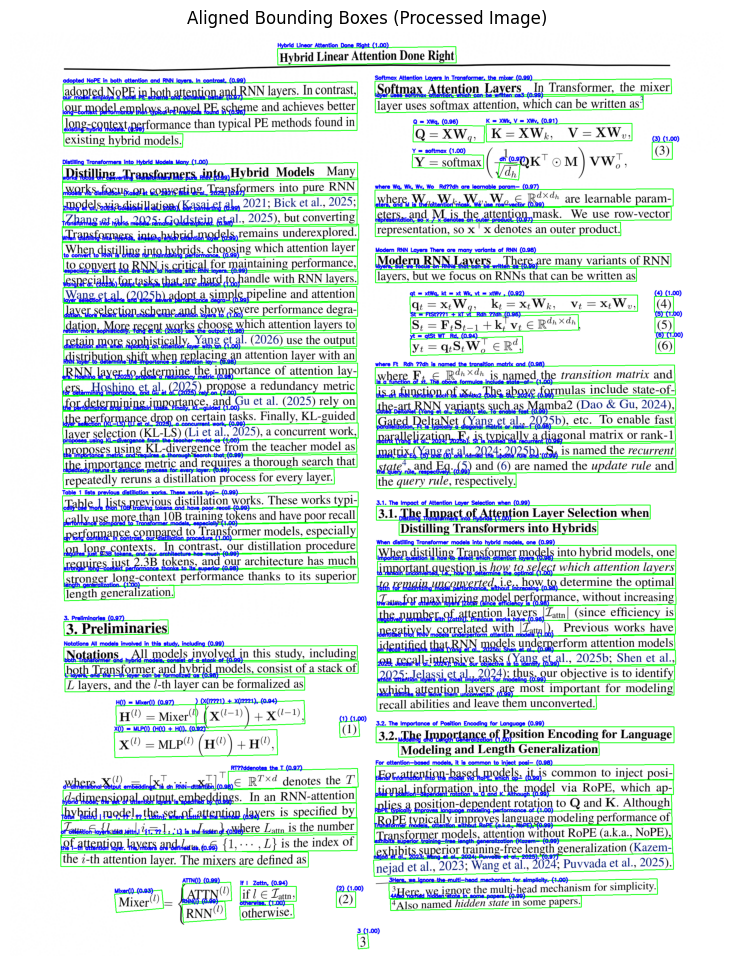

In [17]:
run_paddle('c:/Users/manel/OneDrive/Escritorio/OCR/DocumentAgent/data/images/page_3.png')

### Observations

### Execution4

text                                          |   conf | box
---------------------------------------------------------------------------------------
98.4                                          |  1.000 | [[1993, 395], [2073, 395], [2073, 437], [1993, 437]]
14.8                                          |  1.000 | [[2106, 397], [2183, 397], [2183, 436], [2106, 436]]
96.4                                          |  1.000 | [[1228, 381], [1309, 381], [1309, 424], [1228, 424]]
99.8                                          |  1.000 | [[1022, 450], [1104, 450], [1104, 491], [1022, 491]]
84.0                                          |  1.000 | [[1894, 464], [1974, 464], [1974, 506], [1894, 506]]
32K                                           |  1.000 | [[1021, 304], [1105, 304], [1105, 345], [1021, 345]]
15.4                                          |  1.000 | [[1992, 466], [2072, 466], [2072, 507], [1992, 507]]
14.8                                          |  1.000 | [[1345, 500], [1428, 500

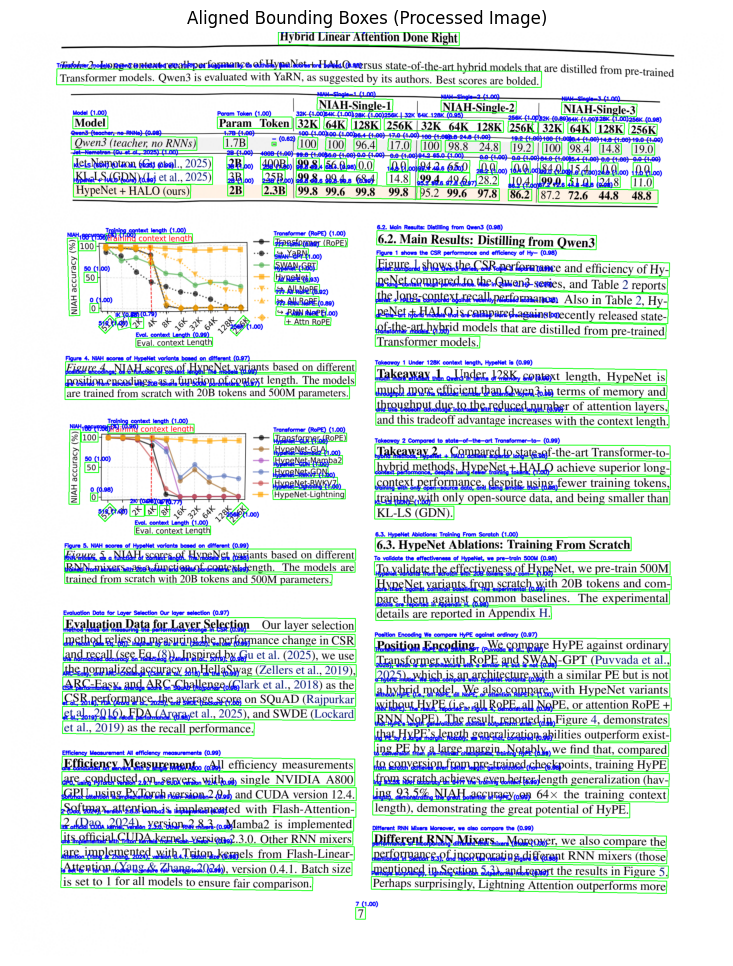

In [18]:
run_paddle('c:/Users/manel/OneDrive/Escritorio/OCR/DocumentAgent/data/images/page_7.png')

### Execution4

text                                          |   conf | box
---------------------------------------------------------------------------------------
1858                                          |  1.000 | [[392, 2294], [496, 2294], [496, 2343], [392, 2343]]
paragraph                                     |  1.000 | [[243, 292], [466, 296], [465, 345], [242, 341]]
1096                                          |  1.000 | [[391, 2357], [496, 2357], [496, 2406], [391, 2406]]
Neuron                                        |  1.000 | [[348, 2227], [535, 2230], [534, 2279], [348, 2277]]
layer.                                        |  1.000 | [[214, 2158], [339, 2161], [338, 2216], [212, 2213]]
+2.30                                         |  1.000 | [[781, 2420], [907, 2420], [907, 2467], [781, 2467]]
+2.05                                         |  1.000 | [[780, 2292], [906, 2290], [907, 2337], [781, 2339]]
3                                             |  1.000 | [[261, 2426], [298, 2426], [

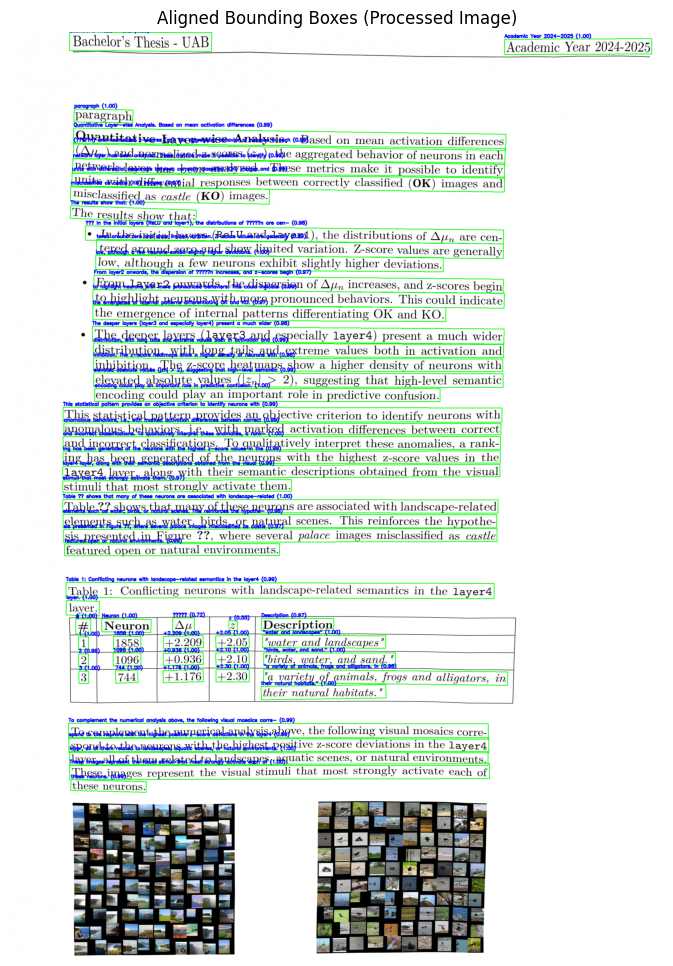

In [19]:
run_paddle('c:/Users/manel/OneDrive/Escritorio/OCR/DocumentAgent/data/images/TFG1.png')

### Observations